In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityajn105","key":"571939f74e6a6e23ec01a7d769da7958"}'}

In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c recognizing-faces-in-the-wild
!mkdir train test
!unzip -q train.zip -d train
!unzip -q test.zip -d test
!rm train.zip test.zip

  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 30.0MB/s]
100% 34.0M/34.1M [00:00<00:00, 50.2MB/s]
100% 34.1M/34.1M [00:00<00:00, 135MB/s] 
 93% 64.0M/68.6M [00:00<00:00, 15.9MB/s]
100% 68.6M/68.6M [00:00<00:00, 78.3MB/s]
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 135MB/s]


In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-n373etd_
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-n373etd_
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxk6bher/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
import gc
import cv2
import glob
import numpy as np
from keras_vggface.utils import preprocess_input

def read_img(path):
  img = cv2.imread(path)
  img = np.array(img).astype(np.float)
  return preprocess_input(img,version=2)

Using TensorFlow backend.


In [0]:
from collections import defaultdict
allPhotos = defaultdict(list)
for family in glob.glob("train/*"):
  for mem in glob.glob(family+'/*'):
    for photo in glob.glob(mem+'/*'):
      allPhotos[mem].append(photo)
ppl = list(allPhotos.keys())
len(ppl)

2316

In [0]:
import pandas as pd
import numpy as np
data = pd.read_csv('train_relationships.csv')
data.p1 = data.p1.apply( lambda x: 'train/'+x )
data.p2 = data.p2.apply( lambda x: 'train/'+x )
print(data.shape)
data.head()

(3598, 2)


,p1,p2
0,train/F0002/MID1,train/F0002/MID3
1,train/F0002/MID2,train/F0002/MID3
2,train/F0005/MID1,train/F0005/MID2
3,train/F0005/MID3,train/F0005/MID2
4,train/F0009/MID1,train/F0009/MID4


In [0]:
data = data[ ( (data.p1.isin(ppl)) & (data.p2.isin(ppl)) ) ]
data = [ ( x[0], x[1]  ) for x in data.values ]
len(data)

3362

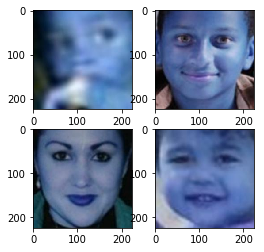

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, sample

f, ax = plt.subplots(2, 2, figsize=(4, 4))
batch = sample(data,2)
for i,j in [(0,0),(0,1),(1,0),(1,1)]:
  ax[i][j].imshow( cv2.imread( choice(allPhotos[batch[i][j]]) ) )

In [0]:
train = [ x for x in data if 'F09' not in x[0]  ]
val = [ x for x in data if 'F09' in x[0]  ]
len(train), len(val)

(3066, 296)

In [0]:
del data; gc.collect();

In [0]:
def getImages(p1,p2):
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
  p1 = []; p2 = []; Y = []
  batch = sample(data, batch_size//2)
  for x in batch:
    _p1, _p2 = getImages(*x)
    p1.append(_p1);p2.append(_p2);Y.append(1)
  while len(Y) < batch_size:
    _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
    if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
      _p1,_p2 = getImages(_p1,_p2)
      p1.append(_p1);p2.append(_p2);Y.append(0) 
  return [np.array(p1),np.array(p2)], np.array(Y)

In [0]:
from keras_vggface.vggface import VGGFace

IMG_DIM = (224,224,3)

vggface = VGGFace(model='resnet50', include_top=False)

for layer in vggface.layers[:-60]:
  layer.trainable=False

In [0]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [0]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model 
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])


# h1^2
x6 = Lambda(lambda tensor  : K.square(tensor))(x1)
# h2^2
x7 = Lambda(lambda tensor  : K.square(tensor))(x2)

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.1)(x)

prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

In [0]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading

reducelr = ReduceLROnPlateau(monitor='val_loss', mode='min',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size, data ):
  while True:
    yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = siamese_net.fit_generator( train_gen, samples_per_epoch=200, epochs=100, 
                          validation_data=val_gen, validation_steps=100, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list, workers=4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=100, validation_data=<generator..., validation_steps=100, use_multiprocessing=True, verbose=1, callbacks=[<keras.ca..., workers=4, steps_per_epoch=200)`
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
200/200 [==============================] - 88s 442ms/step - loss: 0.7277 - acc: 0.5600 - auc: 0.5896 - val_loss: 0.6927 - val_acc: 0.6256 - val_auc: 0.6958

Epoch 00001: val_auc improved from -inf to 0.69578, saving model to model_best_checkpoint.h5
Epoch 2/100
200/200 [==============================] - 59s 293ms/step - loss: 0.6724 - acc: 0.6413 - auc: 0.7006 - val_loss: 0.6655 - val_acc: 0.6400 - val_auc: 0.7259

Epoch 00002: val_auc improved from 0.69578 to 0.72594, saving model to model_best_checkpoint.h5
Epoch 3/100
200/200 [==============================] - 59s 294ms/step - loss: 0.6103 - acc: 0.6959 - auc: 0.7709 - val_loss: 0.6632 - val_acc: 0.6687 - val_auc: 0.7608

Epoch 00003: val_auc improved from 0.72594 to 0.76078, saving model to model_best_checkpoint.h5
Epoch 4/100
200/200 [==============================] - 60s 298ms/step - loss: 0.5684 - acc: 0.7419 - auc: 0.8204 - val_loss: 0.6490 - val_acc: 0.6719 - val_auc: 0.7767

Epoch 00004: val_auc improved from 0.76

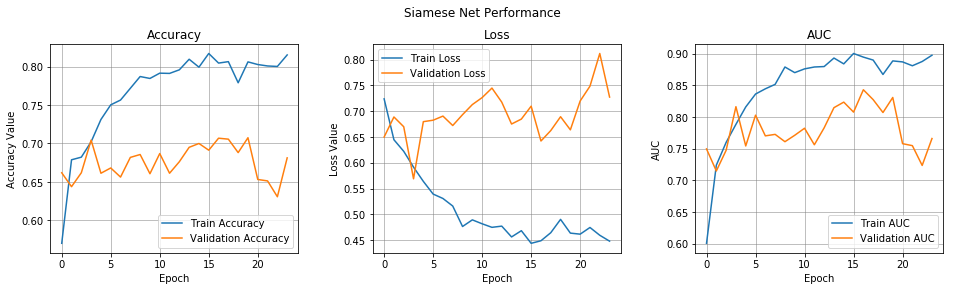

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [0]:
siamese_net.load_weights('model_best_checkpoint.h5')

In [30]:
submission = pd.read_csv('sample_submission.csv')
submission['p1'] = submission.img_pair.apply( lambda x: 'test/'+x.split('-')[0] )
submission['p2'] = submission.img_pair.apply( lambda x: 'test/'+x.split('-')[1] )
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,test/face05508.jpg,test/face01210.jpg
1,face05750.jpg-face00898.jpg,0,test/face05750.jpg,test/face00898.jpg
2,face05820.jpg-face03938.jpg,0,test/face05820.jpg,test/face03938.jpg
3,face02104.jpg-face01172.jpg,0,test/face02104.jpg,test/face01172.jpg
4,face02428.jpg-face05611.jpg,0,test/face02428.jpg,test/face05611.jpg


In [31]:
from tqdm import tqdm

probs = []
for i,j in tqdm([ (0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),
                 (2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,5000),(5000,5310) ]):
  imgs1 = np.array( [ read_img(photo) for photo in submission.p1.values[i:j] ] )
  imgs2 = np.array( [ read_img(photo) for photo in submission.p2.values[i:j] ] )
  prob =  siamese_net.predict( [ imgs1, imgs2 ] )
  probs.append(np.squeeze(prob))
  del imgs1,imgs2; gc.collect()

100%|██████████| 11/11 [01:25<00:00,  6.80s/it]


In [34]:
submission.is_related = np.concatenate(probs)
submission.drop( ['p1','p2'],axis=1,inplace=True )
submission.head()

KeyError: ignored

In [0]:
submission.to_csv('submission.csv',index=False)

In [39]:
!kaggle competitions submit -c recognizing-faces-in-the-wild -f submission.csv -m "10th vgg-face resnet(60 train) all-imgs adam(1e-5) earlystop arch-2 (extra layer after vgg)"

100% 201k/201k [00:01<00:00, 110kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (8.8 hours from now).
